In [1]:
!pip install torchinfo

### Import Libraries

In [2]:
# <<< CHANGED: consolidated imports and added compatibility helpers
import os
import time
import random
import platform
import psutil
import glob
from collections import OrderedDict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchinfo import summary
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [3]:
# <<< UNCHANGED
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


### Configuration

In [4]:
# <<< CHANGED: set DATA_ROOT to your dataset folder under /kaggle/input
cpu_info = platform.processor()
ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

# UPDATE this to the actual dataset folder you see in /kaggle/input
DATA_ROOT = "/kaggle/input/augmented"   # <<< CHANGE this if needed

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("DATA_ROOT exists:", os.path.exists(DATA_ROOT))

CPU: x86_64
Total RAM (GB): 31.35
DATA_ROOT exists: True


### Seed Value

In [5]:
# <<< UNCHANGED (but add deterministic settings)
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Loading Dataset

In [6]:
DATA_ROOT = "/kaggle/input/augmented"
# <<< CHANGED: dynamic discovery of class folders and files
file_paths = []
labels = []

for class_name in sorted(os.listdir(DATA_ROOT)):
    class_dir = os.path.join(DATA_ROOT, class_name)
    if not os.path.isdir(class_dir):
        continue
    for image_name in os.listdir(class_dir):
        fp = os.path.join(class_dir, image_name)
        if os.path.isfile(fp):
            file_paths.append(fp)
            labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Class: _NORMAL T1, Count: 369
Class: Granuloma T1, Count: 369
Class: Meningioma T1, Count: 369
Class: Carcinoma T1, Count: 369
Class: Astrocitoma T1C+, Count: 369
Class: Meningioma T2, Count: 369
Class: Tuberculoma T1C+, Count: 369
Class: Neurocitoma T1C+, Count: 369
Class: Schwannoma T2, Count: 369
Class: Neurocitoma T2, Count: 369
Class: Tuberculoma T2, Count: 369
Class: Meduloblastoma T1, Count: 369
Class: Ganglioglioma T2, Count: 369
Class: Schwannoma T1, Count: 369
Class: Germinoma T2, Count: 369
Class: Oligodendroglioma T2, Count: 369
Class: Ependimoma T1C+, Count: 369
Class: Schwannoma T1C+, Count: 369
Class: Meduloblastoma T2, Count: 369
Class: Germinoma T1C+, Count: 369
Class: Ependimoma T1, Count: 369
Class: Ganglioglioma T1C+, Count: 369
Class: Oligodendroglioma T1C+, Count: 369
Class: Ependimoma T2, Count: 369
Class: Carcinoma T1C+, Count: 369
Class: Meningioma T1C+, Count: 369
Class: _NORMAL T2, Count: 369
Class: Meduloblastoma T1C+, Count: 369
Class: Tuberculoma T1, Count

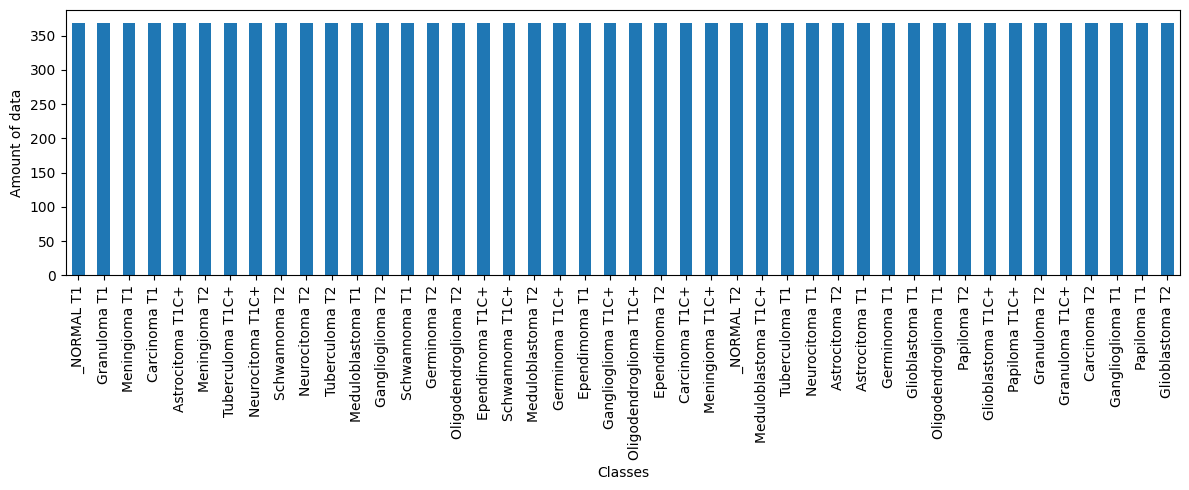

In [7]:
class_counts_all = df['label'].value_counts()
for class_name, count in class_counts_all.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(12,5))
ax = class_counts_all.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

(-0.5, 629.5, 629.5, -0.5)

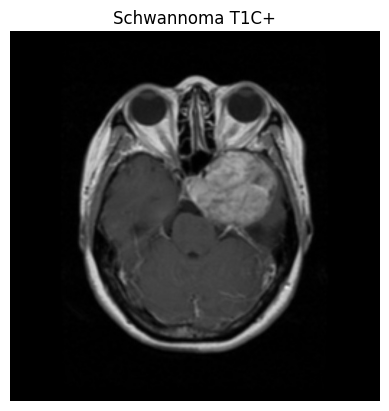

In [8]:
# Show a sample image (sanity)
random_index = random.randint(0, len(df) - 1)
random_row = df.iloc[random_index]
image = Image.open(random_row['file_path']).convert('RGB')
plt.imshow(image); plt.title(random_row['label']); plt.axis('off')

### Train-Test-Validation Split (Ratio 70:15:15)

In [9]:
# <<< UNCHANGED (stratified 70:15:15)
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, stratify=temp_dataframe['label'], random_state=42)

In [10]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  11365
Validation Data:  2435
Test Data:  2436
-------------------------------------------
Total amounts of data in the dataset:  16236


In [11]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test  = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data  = [[class_name, count] for class_name, count in class_counts_test.items()]

print("\nTrain dataset class counts:")
print(train_dataframe['label'].value_counts())
print("\nValid dataset class counts:")
print(valid_dataframe['label'].value_counts())
print("\nTest dataset class counts:")
print(test_df['label'].value_counts())


Train dataset class counts:
label
Schwannoma T1C+           259
Germinoma T1              259
Papiloma T1C+             259
Tuberculoma T1C+          259
Ependimoma T1             259
Meningioma T1             259
Meningioma T1C+           259
Neurocitoma T1            259
Carcinoma T1              259
Ependimoma T2             259
Schwannoma T1             259
Carcinoma T1C+            259
Oligodendroglioma T1C+    259
Astrocitoma T2            258
Astrocitoma T1            258
Tuberculoma T1            258
_NORMAL T1                258
Meduloblastoma T2         258
Glioblastoma T1           258
Germinoma T2              258
Granuloma T1              258
Astrocitoma T1C+          258
Oligodendroglioma T1      258
Oligodendroglioma T2      258
Germinoma T1C+            258
Neurocitoma T2            258
Glioblastoma T2           258
Neurocitoma T1C+          258
_NORMAL T2                258
Granuloma T2              258
Tuberculoma T2            258
Ganglioglioma T1C+        258
Carci

### Checkpoint

In [12]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Dataset Class, Dataloader and Transform

In [13]:
# <<< CHANGED: dynamic label mapping, safer transforms, WeightedRandomSampler, Kaggle-safe loaders

# Label mapping from train split (ensures consistent mapping)
classes = sorted(train_dataframe['label'].unique().tolist())
label_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_label = {i: c for c, i in label_to_idx.items()}
num_classes = len(classes)
print("Detected number of classes:", num_classes)

# Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.08),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

eval_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform, label_to_idx):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label_to_idx = label_to_idx
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img = Image.open(row['file_path']).convert('RGB')   # force RGB
        img = self.transform(img)
        label = self.label_to_idx[row['label']]
        return img, label

Detected number of classes: 44


In [14]:

# Dataloader parameters
train_batch = 16   # safe default; reduce to 8 if OOM
val_batch = 16
num_workers = 0    # Kaggle-safe

def make_loaders():
    train_ds = ImageDataset(train_dataframe, train_transform, label_to_idx)
    valid_ds = ImageDataset(valid_dataframe, eval_transform, label_to_idx)
    test_ds  = ImageDataset(test_df, eval_transform, label_to_idx)

    # compute class sample weights (inverse frequency)
    train_counts = train_dataframe['label'].value_counts().to_dict()
    class_sample_count = np.array([train_counts.get(c, 0) for c in classes], dtype=np.float32)
    class_sample_count[class_sample_count == 0] = 1.0
    weights_per_class = 1.0 / class_sample_count

    labels_train_idx = train_dataframe['label'].map(label_to_idx).values
    sample_weights = torch.DoubleTensor([weights_per_class[l] for l in labels_train_idx])

    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=train_batch, sampler=sampler, num_workers=num_workers, pin_memory=True)
    valid_loader = DataLoader(valid_ds, batch_size=val_batch, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=val_batch, shuffle=False, num_workers=num_workers, pin_memory=True)

    class_weights = torch.FloatTensor(weights_per_class / weights_per_class.mean())  # normalized weights for criterion
    return train_loader, valid_loader, test_loader, class_weights

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset, class_weights = make_loaders()
print("Dataloaders ready. Train batches:", len(dataloader_train_dataset))

Dataloaders ready. Train batches: 711


### Convolutional Neural Network

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# -----------------------------
# Define Conv Block
# -----------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


# -----------------------------
# Residual Block
# -----------------------------
class ResidualSimple(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(ch, ch, kernel=1, padding=0),
            ConvBlock(ch, ch, kernel=3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)


# -----------------------------
# Better Simple CNN
# -----------------------------
class BetterSimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Stem (input -> 32 channels)
        self.stem = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d(2)  # Output: 112x112
        )

        # Layer 1 (32 -> 64)
        self.layer1 = nn.Sequential(
            ConvBlock(32, 64),
            ConvBlock(64, 64),
            nn.MaxPool2d(2),  # Output: 56x56
            ResidualSimple(64)
        )

        # Layer 2 (64 -> 128)
        self.layer2 = nn.Sequential(
            ConvBlock(64, 128),
            ConvBlock(128, 128),
            nn.MaxPool2d(2),  # Output: 28x28
            ResidualSimple(128)
        )

        # Layer 3 (128 -> 256)
        self.layer3 = nn.Sequential(
            ConvBlock(128, 256),
            ConvBlock(256, 256),
            nn.MaxPool2d(2),  # Output: 14x14
            ResidualSimple(256)
        )

        # Global pooling + dropout + fc
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(256, num_classes)

        # Init weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_pool(x).view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [16]:
# -----------------------------
# Instantiate Model
# -----------------------------
total_class = num_classes
model = BetterSimpleCNN(num_classes=total_class).to(device)

# Weighted cross-entropy with label smoothing
class_weights_tensor = class_weights.to(device)
criterion = nn.CrossEntropyLoss(
    weight=class_weights_tensor,
    label_smoothing=0.1
).to(device)

# AdamW optimizer
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# CosineAnnealingWarmRestarts scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=5, T_mult=2
)

# Optional: check model summary
# from torchsummary import summary
# summary(model, input_size=(train_batch, 3, 224, 224))

### Training

In [17]:
import torch
from torch.cuda.amp import GradScaler
from tqdm import tqdm
import os
import time
import pandas as pd
import inspect

# -----------------------------
# Robust autocast wrapper
# -----------------------------
def get_autocast_ctx():
    try:
        from torch.amp import autocast as autocast_mod
    except Exception:
        from torch.cuda.amp import autocast as autocast_mod
    sig = inspect.signature(autocast_mod)
    if 'device_type' in sig.parameters:
        device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
        if 'dtype' in sig.parameters:
            def autocast_ctx(): return autocast_mod(device_type=device_type, dtype=torch.float16)
        else:
            def autocast_ctx(): return autocast_mod(device_type=device_type)
    else:
        def autocast_ctx(): return autocast_mod()
    return autocast_ctx

autocast_ctx = get_autocast_ctx()

In [18]:
# -----------------------------
# Training Function
# -----------------------------
def train_model(model, criterion, optimizer, scheduler,
                train_loader, valid_loader,
                num_epochs=30, early_stop_patience=7, save_path=save_path_checkpoints):

    model = model.to(device)
    os.makedirs(save_path, exist_ok=True)

    best_val_acc, best_epoch = 0.0, -1
    scaler_local = GradScaler()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    no_improve = 0

    for epoch in range(1, num_epochs + 1):
        start_epoch = time.time()
        print("="*72)
        print(f"Epoch {epoch}/{num_epochs}")

        # ---------- TRAIN ----------
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0
        pbar = tqdm(train_loader, desc=f"Train {epoch}/{num_epochs}", leave=False)

        for images, labels in pbar:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            with autocast_ctx():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler_local.scale(loss).backward()
            scaler_local.unscale_(optimizer)  # gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            scaler_local.step(optimizer)
            scaler_local.update()

            preds = outputs.argmax(dim=1)
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
            running_loss += loss.item() * labels.size(0)

            pbar.set_postfix({'loss': f"{running_loss/running_total:.4f}",
                              'acc':  f"{running_correct/running_total:.4f}"})

        train_loss = running_loss / running_total
        train_acc  = running_correct / running_total

        # ---------- VALIDATE ----------
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            vbar = tqdm(valid_loader, desc=f"Valid {epoch}/{num_epochs}", leave=False)
            for images, labels in vbar:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                with autocast_ctx():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                preds = outputs.argmax(dim=1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()
                val_loss += loss.item() * labels.size(0)

                vbar.set_postfix({'vloss': f"{val_loss/val_total:.4f}",
                                  'vacc':  f"{val_correct/val_total:.4f}"})

        val_loss_epoch = val_loss / val_total
        val_acc_epoch  = val_correct / val_total

        # record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss_epoch)
        history['val_acc'].append(val_acc_epoch)

        epoch_time = time.time() - start_epoch
        print(f"Epoch {epoch} done in {epoch_time:.1f}s | "
              f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} | "
              f"Val Loss {val_loss_epoch:.4f} Acc {val_acc_epoch:.4f}")

        # ---------- Checkpoint best ----------
        if val_acc_epoch > best_val_acc:
            best_val_acc = val_acc_epoch
            best_epoch = epoch
            ckpt = {"epoch": epoch, "model_state": model.state_dict(), "optim_state": optimizer.state_dict()}
            torch.save(ckpt, os.path.join(save_path, f"best_model_epoch{epoch}.pt"))
            print(f"  Best model saved at epoch {epoch} (val_acc={val_acc_epoch:.4f})")
            no_improve = 0
        else:
            no_improve += 1

        # early stopping
        if no_improve >= early_stop_patience:
            print(f"Early stopping: no improvement for {early_stop_patience} epochs.")
            break

        # scheduler step
        if isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
            scheduler.step(epoch + 1)  # fractional epoch step
        else:
            try:
                scheduler.step(val_loss_epoch)
            except Exception:
                scheduler.step()

    print("Training finished. Best val acc:", best_val_acc, "at epoch", best_epoch)
    return history, best_epoch

# -----------------------------
# Run Training
# -----------------------------
start_time = time.time()
history, best_epoch = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=dataloader_train_dataset,
    valid_loader=dataloader_valid_dataset,
    num_epochs=30,
    early_stop_patience=7,
    save_path=save_path_checkpoints
)
end_time = time.time()
print(f"Training Time: {end_time-start_time:.2f}s ({(end_time-start_time)/60:.2f} min)")

# Save history to Excel
hist_df = pd.DataFrame({
    'Epoch': list(range(1, len(history['train_loss']) + 1)),
    'Train Loss': history['train_loss'],
    'Train Accuracy': history['train_acc'],
    'Validation Loss': history['val_loss'],
    'Validation Accuracy': history['val_acc']
})
os.makedirs(save_path_checkpoints, exist_ok=True)
hist_df.to_excel(os.path.join(save_path_checkpoints, "training_data.xlsx"), index=False)
print("History saved to:", os.path.join(save_path_checkpoints, "training_data.xlsx"))

/tmp/ipykernel_19/2629688464.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_local = GradScaler()


Epoch 1/30


Epoch 1 done in 207.1s | Train Loss 3.4670 Acc 0.1028 | Val Loss 3.1400 Acc 0.1713
  Best model saved at epoch 1 (val_acc=0.1713)
Epoch 2/30


Epoch 2 done in 175.4s | Train Loss 3.0043 Acc 0.2245 | Val Loss 2.7457 Acc 0.3101
  Best model saved at epoch 2 (val_acc=0.3101)
Epoch 3/30


Epoch 3 done in 165.9s | Train Loss 2.7058 Acc 0.3156 | Val Loss 2.4874 Acc 0.3918
  Best model saved at epoch 3 (val_acc=0.3918)
Epoch 4/30


Epoch 4 done in 164.7s | Train Loss 2.5401 Acc 0.3845 | Val Loss 2.3409 Acc 0.4702
  Best model saved at epoch 4 (val_acc=0.4702)
Epoch 5/30


Epoch 5 done in 162.1s | Train Loss 2.5483 Acc 0.3623 | Val Loss 2.5686 Acc 0.3585
Epoch 6/30


Epoch 6 done in 161.9s | Train Loss 2.3374 Acc 0.4453 | Val Loss 2.2955 Acc 0.4407
Epoch 7/30


Epoch 7 done in 161.5s | Train Loss 2.1680 Acc 0.5083 | Val Loss 2.0426 Acc 0.5877
  Best model saved at epoch 7 (val_acc=0.5877)
Epoch 8/30


Epoch 8 done in 163.9s | Train Loss 2.0092 Acc 0.5725 | Val Loss 1.8511 Acc 0.6333
  Best model saved at epoch 8 (val_acc=0.6333)
Epoch 9/30


Epoch 9 done in 160.2s | Train Loss 1.8907 Acc 0.6202 | Val Loss 1.7508 Acc 0.6772
  Best model saved at epoch 9 (val_acc=0.6772)
Epoch 10/30


Epoch 10 done in 160.9s | Train Loss 1.7747 Acc 0.6688 | Val Loss 1.6789 Acc 0.7121
  Best model saved at epoch 10 (val_acc=0.7121)
Epoch 11/30


Epoch 11 done in 162.3s | Train Loss 1.6771 Acc 0.7097 | Val Loss 1.4903 Acc 0.7856
  Best model saved at epoch 11 (val_acc=0.7856)
Epoch 12/30


Epoch 12 done in 162.3s | Train Loss 1.6303 Acc 0.7256 | Val Loss 1.4308 Acc 0.8049
  Best model saved at epoch 12 (val_acc=0.8049)
Epoch 13/30


Epoch 13 done in 160.3s | Train Loss 1.5637 Acc 0.7589 | Val Loss 1.3932 Acc 0.8177
  Best model saved at epoch 13 (val_acc=0.8177)
Epoch 14/30


Epoch 14 done in 160.3s | Train Loss 1.5416 Acc 0.7661 | Val Loss 1.3766 Acc 0.8242
  Best model saved at epoch 14 (val_acc=0.8242)
Epoch 15/30


Epoch 15 done in 161.7s | Train Loss 1.7115 Acc 0.6862 | Val Loss 1.6436 Acc 0.7060
Epoch 16/30


Epoch 16 done in 162.2s | Train Loss 1.6582 Acc 0.7121 | Val Loss 1.6218 Acc 0.7207
Epoch 17/30


Epoch 17 done in 162.2s | Train Loss 1.6070 Acc 0.7263 | Val Loss 1.5477 Acc 0.7524
Epoch 18/30


Epoch 18 done in 162.3s | Train Loss 1.5463 Acc 0.7571 | Val Loss 1.5113 Acc 0.7614
Epoch 19/30


Epoch 19 done in 162.7s | Train Loss 1.4685 Acc 0.7862 | Val Loss 1.5263 Acc 0.7532
Epoch 20/30


Epoch 20 done in 161.9s | Train Loss 1.4367 Acc 0.7956 | Val Loss 1.3854 Acc 0.8209
Epoch 21/30


Epoch 21 done in 160.7s | Train Loss 1.3991 Acc 0.8128 | Val Loss 1.3207 Acc 0.8456
  Best model saved at epoch 21 (val_acc=0.8456)
Epoch 22/30


Epoch 22 done in 161.4s | Train Loss 1.3427 Acc 0.8344 | Val Loss 1.2372 Acc 0.8686
  Best model saved at epoch 22 (val_acc=0.8686)
Epoch 23/30


Epoch 23 done in 161.2s | Train Loss 1.2969 Acc 0.8554 | Val Loss 1.2164 Acc 0.8846
  Best model saved at epoch 23 (val_acc=0.8846)
Epoch 24/30


Epoch 24 done in 160.8s | Train Loss 1.2563 Acc 0.8708 | Val Loss 1.1716 Acc 0.8908
  Best model saved at epoch 24 (val_acc=0.8908)
Epoch 25/30


Epoch 25 done in 162.2s | Train Loss 1.2181 Acc 0.8868 | Val Loss 1.1381 Acc 0.9027
  Best model saved at epoch 25 (val_acc=0.9027)
Epoch 26/30


Epoch 26 done in 163.7s | Train Loss 1.1898 Acc 0.8988 | Val Loss 1.1157 Acc 0.9088
  Best model saved at epoch 26 (val_acc=0.9088)
Epoch 27/30


Epoch 27 done in 163.3s | Train Loss 1.1542 Acc 0.9101 | Val Loss 1.0622 Acc 0.9318
  Best model saved at epoch 27 (val_acc=0.9318)
Epoch 28/30


Epoch 28 done in 162.5s | Train Loss 1.1277 Acc 0.9194 | Val Loss 1.0818 Acc 0.9236
Epoch 29/30


Epoch 29 done in 163.1s | Train Loss 1.0977 Acc 0.9313 | Val Loss 1.0346 Acc 0.9450
  Best model saved at epoch 29 (val_acc=0.9450)
Epoch 30/30


Epoch 30 done in 162.6s | Train Loss 1.0822 Acc 0.9395 | Val Loss 1.0246 Acc 0.9429
Training finished. Best val acc: 0.9449691991786447 at epoch 29
Training Time: 4924.56s (82.08 min)
History saved to: /kaggle/working/training_data.xlsx


In [19]:
file_path = os.path.join(save_path_checkpoints, "training_data.xlsx")
print("Looking for file at:", file_path)
print("Exists?", os.path.exists(file_path))

Looking for file at: /kaggle/working/training_data.xlsx
Exists? True


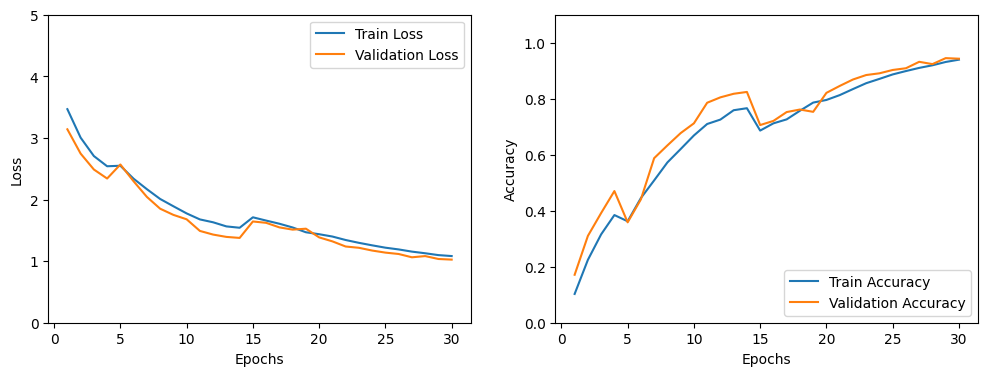

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load history from the same path you saved
history = pd.read_excel(os.path.join(save_path_checkpoints, "training_data.xlsx"))

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Epoch'], history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim(0, 5)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Epoch'], history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1.1)

plt.show()

### Evaluation

In [21]:
# <<< CHANGED: load best checkpoint and evaluate on test set
best_checkpoint_path = os.path.join(save_path_checkpoints, f"best_model_epoch{best_epoch}.pt")
if os.path.exists(best_checkpoint_path):
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    print(f"Loaded best model from epoch {checkpoint['epoch']}")
else:
    print("Best checkpoint not found; using current model.")

def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        with autocast_ctx():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    return running_loss/total, correct/total

best_val_loss, best_val_acc = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_acc:.3f}")

test_loss, test_acc = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}")


Loaded best model from epoch 29
Validation Loss: 1.035, Validation Accuracy: 0.945
Test Loss: 1.048, Test Accuracy: 0.940


In [22]:
start_time = time.time()
test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")
end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.940
Test Time: 17.43 seconds ---> 0.29 minutes


In [23]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_acc = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_acc

# Collect predictions for classification report
y_true, y_pred = [], []
model.eval()
with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [idx_to_label[i] for i in range(num_classes)]  # <<< CHANGED: real names
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

class_acc = class_accuracy(model, dataloader_test_dataset, num_classes)
for i in range(num_classes):
    print(f"Class {i:02d} ({idx_to_label[i]}): Accuracy: {class_acc[i]:.3f}")

/tmp/ipykernel_19/1402858270.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):


Classification Report:
                        precision    recall  f1-score   support

        Astrocitoma T1      0.891     0.875     0.883        56
      Astrocitoma T1C+      0.980     0.857     0.914        56
        Astrocitoma T2      0.889     0.714     0.792        56
          Carcinoma T1      1.000     0.909     0.952        55
        Carcinoma T1C+      0.963     0.945     0.954        55
          Carcinoma T2      0.981     0.945     0.963        55
         Ependimoma T1      1.000     0.891     0.942        55
       Ependimoma T1C+      1.000     0.982     0.991        55
         Ependimoma T2      0.821     1.000     0.902        55
      Ganglioglioma T1      0.966     1.000     0.982        56
    Ganglioglioma T1C+      1.000     1.000     1.000        55
      Ganglioglioma T2      0.946     0.946     0.946        56
          Germinoma T1      0.982     1.000     0.991        55
        Germinoma T1C+      0.964     0.982     0.973        55
          Germin

/tmp/ipykernel_19/1402858270.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):


Class 00 (Astrocitoma T1): Accuracy: 0.875
Class 01 (Astrocitoma T1C+): Accuracy: 0.857
Class 02 (Astrocitoma T2): Accuracy: 0.714
Class 03 (Carcinoma T1): Accuracy: 0.909
Class 04 (Carcinoma T1C+): Accuracy: 0.945
Class 05 (Carcinoma T2): Accuracy: 0.945
Class 06 (Ependimoma T1): Accuracy: 0.891
Class 07 (Ependimoma T1C+): Accuracy: 0.982
Class 08 (Ependimoma T2): Accuracy: 1.000
Class 09 (Ganglioglioma T1): Accuracy: 1.000
Class 10 (Ganglioglioma T1C+): Accuracy: 1.000
Class 11 (Ganglioglioma T2): Accuracy: 0.946
Class 12 (Germinoma T1): Accuracy: 1.000
Class 13 (Germinoma T1C+): Accuracy: 0.982
Class 14 (Germinoma T2): Accuracy: 1.000
Class 15 (Glioblastoma T1): Accuracy: 0.982
Class 16 (Glioblastoma T1C+): Accuracy: 0.982
Class 17 (Glioblastoma T2): Accuracy: 0.964
Class 18 (Granuloma T1): Accuracy: 1.000
Class 19 (Granuloma T1C+): Accuracy: 0.982
Class 20 (Granuloma T2): Accuracy: 1.000
Class 21 (Meduloblastoma T1): Accuracy: 1.000
Class 22 (Meduloblastoma T1C+): Accuracy: 0.982
C